## Importing Libraries

In [5]:
df = pd.read_csv(r'athlete_events.csv', on_bad_lines='skip')

In [6]:
# Clean column names
df.columns = df.columns.str.strip()

# Display column names and data types
print("Column Names:")
print(df.columns)

Column Names:
Index(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal'],
      dtype='object')


In [7]:
# Filter dataset for relevant columns
relevant_columns = ['Name', 'Age', 'Height', 'Weight', 'Team', 'Sport', 'Event', 'Medal']
data = df[relevant_columns].copy()

In [8]:

# Handle numeric conversions safely
data.loc[:, 'Age'] = pd.to_numeric(data['Age'], errors='coerce')
data.loc[:, 'Height'] = pd.to_numeric(data['Height'], errors='coerce')
data.loc[:, 'Weight'] = pd.to_numeric(data['Weight'], errors='coerce')


In [9]:
# Drop rows with missing critical values
data.dropna(subset=['Age', 'Height', 'Weight'], inplace=True)
# Fill missing medal data with "No Medal"
data.loc[:, 'Medal'] = data['Medal'].fillna('No Medal')

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
data[['Age', 'Height', 'Weight']] = scaler.fit_transform(data[['Age', 'Height', 'Weight']])

# Display the first few rows of the cleaned dataset
print(data.head())

                       Name       Age    Height    Weight         Team  \
0                 A Dijiang  0.232558  0.523810  0.444444        China   
1                  A Lamusi  0.209302  0.365079  0.222222        China   
4  Christine Jacoba Aaftink  0.162791  0.603175  0.466667  Netherlands   
5  Christine Jacoba Aaftink  0.162791  0.603175  0.466667  Netherlands   
6  Christine Jacoba Aaftink  0.255814  0.603175  0.466667  Netherlands   

           Sport                               Event     Medal  
0     Basketball         Basketball Men's Basketball  No Medal  
1           Judo        Judo Men's Extra-Lightweight  No Medal  
4  Speed Skating    Speed Skating Women's 500 metres  No Medal  
5  Speed Skating  Speed Skating Women's 1,000 metres  No Medal  
6  Speed Skating    Speed Skating Women's 500 metres  No Medal  


In [10]:
# Covariance matrix for 'Age', 'Height', 'Weight'
covariance_matrix = data[['Age', 'Height', 'Weight']].cov()
print("Covariance Matrix:\n", covariance_matrix)

Covariance Matrix:
              Age    Height    Weight
Age     0.015408  0.003746  0.004588
Height  0.003746  0.027992  0.019649
Weight  0.004588  0.019649  0.025247


In [11]:
# Define Shewhart Control Chart function
def shewhart_control_chart(data, center, UCL, LCL, title, insight):
    plt.figure(figsize=(12, 6))
    plt.plot(data, marker='o', linestyle='-', label='Data')
    plt.axhline(center, color='blue', linestyle='--', label='Center Line')
    plt.axhline(UCL, color='red', linestyle='--', label='UCL')
    plt.axhline(LCL, color='green', linestyle='--', label='LCL')
    plt.title(title)
    plt.legend()
    plt.figtext(0.15, 0.75, insight, wrap=True, horizontalalignment='left', fontsize=12, color='black')
    plt.show()

In [12]:
# Compute control chart limits for 'Age'
center_age = data['Age'].mean()
UCL_age = center_age + 3 * data['Age'].std()
LCL_age = center_age - 3 * data['Age'].std()

In [13]:
# Detect anomalies based on control limits
anomalies_age = data[(data['Age'] > UCL_age) | (data['Age'] < LCL_age)]
print("Anomalies Detected in Age:\n", anomalies_age[['Name', 'Age']])


Anomalies Detected in Age:
                           Name       Age
89            Jan-Erik Aarberg  0.674419
90            Jan-Erik Aarberg  0.767442
126                 Hans Aasns  0.720930
127                 Hans Aasns  0.813953
128                 Hans Aasns  0.906977
129                 Hans Aasns  1.000000
269  William "Bill" Abbott Jr.  0.651163
270  William "Bill" Abbott Jr.  0.744186
737  Julianne "Anne" Abernathy  0.697674
738  Julianne "Anne" Abernathy  0.790698
755       Koutoua Francis Abia  0.651163
756       Koutoua Francis Abia  0.651163


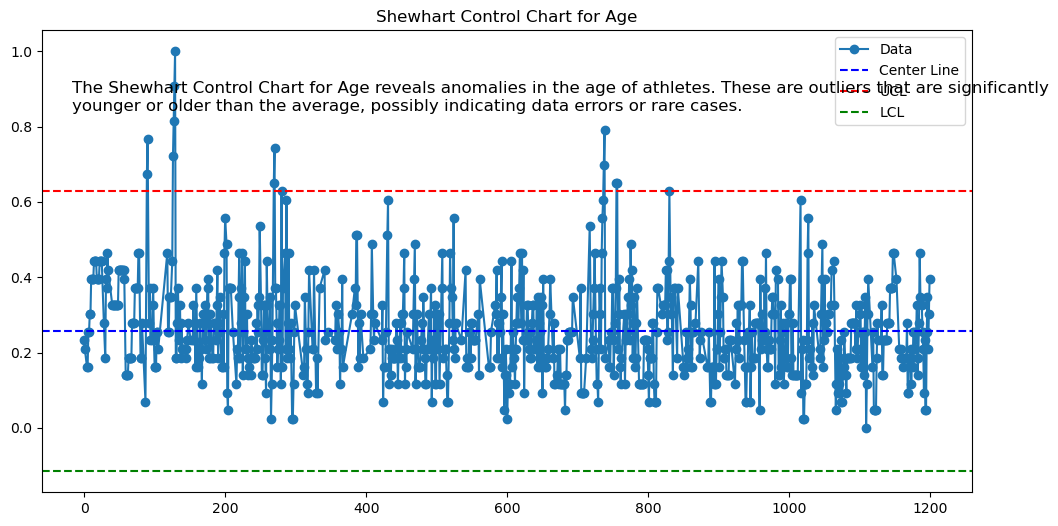

In [14]:
# Plot Shewhart Control Chart for Age
insight_age = "The Shewhart Control Chart for Age reveals anomalies in the age of athletes. These are outliers that are significantly younger or older than the average, possibly indicating data errors or rare cases."
shewhart_control_chart(data['Age'], center_age, UCL_age, LCL_age, 'Shewhart Control Chart for Age', insight_age)

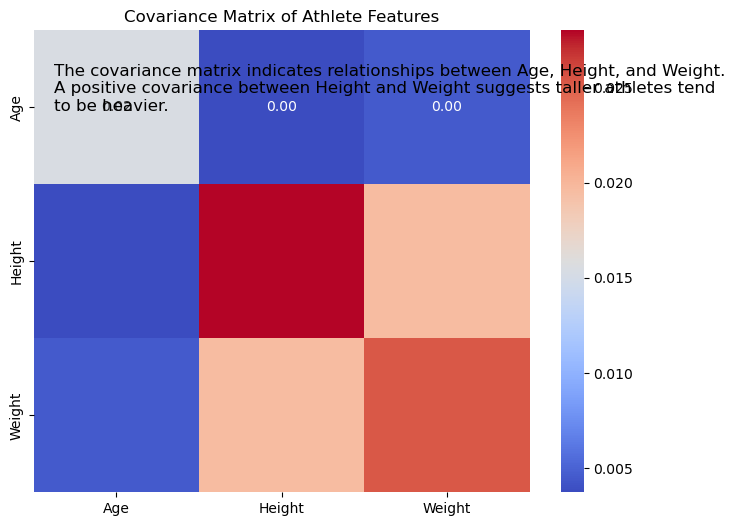

In [15]:
# Plot Covariance Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Covariance Matrix of Athlete Features')
plt.figtext(0.15, 0.75, "The covariance matrix indicates relationships between Age, Height, and Weight. A positive covariance between Height and Weight suggests taller athletes tend to be heavier.", wrap=True, horizontalalignment='left', fontsize=12, color='black')
plt.show()

In [16]:
# Define quadratic optimization problem for performance metric
def performance_metric_quadratic(weights):
    # Quadratic objective: Assume weights are squared to penalize deviations from ideal values
    features = data[['Age', 'Height', 'Weight']].values
    quadratic_term = np.dot(weights.T, np.dot(np.cov(features.T), weights))  # Quadratic term (penalizing variance)
    linear_term = -np.dot(features, weights).mean()  # Linear term (to maximize performance)
    return quadratic_term + linear_term  # Combining quadratic and linear terms


In [17]:
# Constraints: weights must sum to 1 and be non-negative
constraints = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},  # Weights sum to 1
               {'type': 'ineq', 'fun': lambda x: x})             # Weights >= 0

In [18]:
initial_weights = np.array([0.33, 0.33, 0.33])  # Start with equal weights
result = minimize(performance_metric_quadratic, initial_weights, constraints=constraints)

In [19]:
optimal_weights = result.x
print("Optimal Weights for Athlete Performance:", optimal_weights)

Optimal Weights for Athlete Performance: [-1.08121877e-15  1.00000000e+00 -2.22044605e-16]


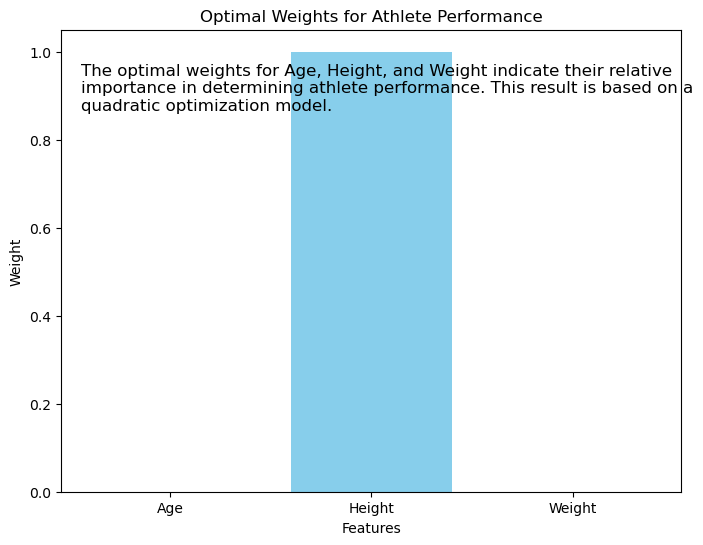

In [20]:
# Plot Optimal Weights as Bar Chart
plt.figure(figsize=(8, 6))
plt.bar(['Age', 'Height', 'Weight'], optimal_weights, color='skyblue')
plt.title('Optimal Weights for Athlete Performance')
plt.xlabel('Features')
plt.ylabel('Weight')
plt.figtext(0.15, 0.75, "The optimal weights for Age, Height, and Weight indicate their relative importance in determining athlete performance. This result is based on a quadratic optimization model.", wrap=True, horizontalalignment='left', fontsize=12, color='black')
plt.show()

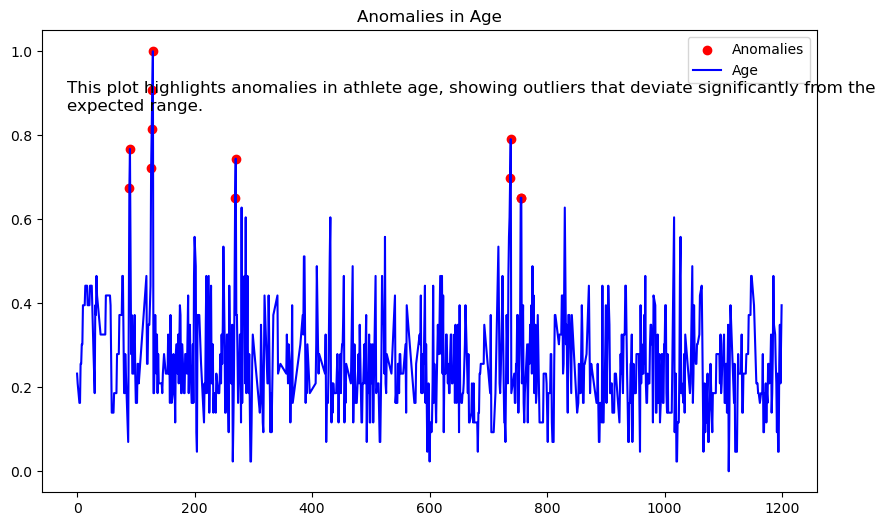

In [21]:
# Plot anomalies in Age
plt.figure(figsize=(10, 6))
plt.scatter(anomalies_age.index, anomalies_age['Age'], color='red', label='Anomalies')
plt.plot(data['Age'], color='blue', label='Age')
plt.title('Anomalies in Age')
plt.legend()
plt.figtext(0.15, 0.75, "This plot highlights anomalies in athlete age, showing outliers that deviate significantly from the expected range.", wrap=True, horizontalalignment='left', fontsize=12, color='black')
plt.show()